# Predicting return from Gold

## Importing and Preparing Data

For this and subsequent exercises we will need closing price of several instruments for past 10 years . There are various paid (Reuters, Bloomberg) and free resources (IEX, Quandl, Yahoofinance, Google finance) that we can use to either extract and load data in csv or we can directly call their APIs. Since in this project I needed different type of asset classes (Equities, Commodities, Debt and precious metals) I found the 'yahoofinancials' package to be very helpful and straight forward. (https://pypi.org/project/yahoofinancials/)

### Installing Libraries

In [19]:
#pip install pycaret

In [20]:
#pip install yahoofinancials

In [1]:
#Importing Libraries
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from yahoofinancials import YahooFinancials
import numpy as np


#### Only if you are running this on google colab to load Drive
from google.colab import drive
drive.mount('/content/drive')

I have prepared a list instruments for which we need to import data. yahoofinancials package requires Yahoo ticker symbols. The list contains the ticker symbols and their descriptions. The excel file containing the list can be found here..... We import that file and extract the tciker symbols and the names as seprarate lists

In [2]:
ticker_details = pd.read_excel("Ticker List.xlsx")
ticker_details.head(20)

,Ticker,Description
0,GC=F,Gold
1,SI=F,Silver
2,CL=F,Crude Oil
3,^GSPC,S&P500
4,^RUT,Russel 2000 Index
5,ZN=F,10 Yr US T-Note futures
6,ZT=F,2 Yr US T-Note Futures
7,PL=F,Platinum
8,HG=F,Copper
9,DX=F,Dollar Index


In [3]:
ticker = ticker_details['Ticker'].to_list()
names = ticker_details['Description'].to_list()

Once we have the list, we need to define what date range we need to import the data for. The period I have chosen is Jan 2010 till 1st Mar 2020. The reason I did not pull data prior to that is because the GFC in 2008-09 massively changed the economic and market landscapes. Relationships pririo to that peirod might be of less relevance now. We also dont want to feed very less data as the models might tend to overfit.

We create a date-range and write it to an empty dataframe named values where we would extract and past the values we pull from yahoofinancials.

In [4]:
#Extracting Data from Yahoo Finance and Adding them to Values table using date as key
end_date= "2020-03-01"
start_date = "2010-01-01"
date_range = pd.bdate_range(start=start_date,end=end_date)
values = pd.DataFrame({ 'Date': date_range})
values['Date']= pd.to_datetime(values['Date'])

Once we have the date range in dataframe, we need to use ticker symbols to pull out data from the API. yahoofinancials returns the output in a JSON format. The following code loops over the the list of ticker symbols and extracts just the closing prices for all the historical dates and keeps them adding to the dataframe horizontally. Note I have used the merge function to mantain the sanctity of dates. Given these asset classes might have different regional and trading holidays, the date ranges are not bound to be the same. By merging, we will eventually have several NAs which we will frontfill later on.

In [5]:
#Extracting Data from Yahoo Finance and Adding them to Values table using date as key
for i in ticker:
    raw_data = YahooFinancials(i)
    raw_data = raw_data.get_historical_price_data(start_date, end_date, "daily")
    df = pd.DataFrame(raw_data[i]['prices'])[['formatted_date','adjclose']]
    df.columns = ['Date1',i]
    df['Date1']= pd.to_datetime(df['Date1'])
    values = values.merge(df,how='left',left_on='Date',right_on='Date1')
    values = values.drop(labels='Date1',axis=1)

#Renaming columns to represent instrument names rather than their ticker codes for ease of readability
names.insert(0,'Date')
values.columns = names
print(values.shape)
print(values.isna().sum())
values.tail()

(2651, 17)
Date                         0
Gold                       117
Silver                     117
Crude Oil                  116
S&P500                      95
Russel 2000 Index           95
10 Yr US T-Note futures    118
2 Yr US T-Note Futures     116
Platinum                   117
Copper                     117
Dollar Index               121
Volatility Index            95
Soybean                    116
MSCI EM ETF                 95
Euro USD                   311
Euronext100                 55
Nasdaq                      95
dtype: int64


,Date,Gold,Silver,Crude Oil,S&P500,Russel 2000 Index,10 Yr US T-Note futures,2 Yr US T-Note Futures,Platinum,Copper,Dollar Index,Volatility Index,Soybean,MSCI EM ETF,Euro USD,Euronext100,Nasdaq
2646,2020-02-24,1672.400024,18.868000,51.430000,3225.889893,1628.099976,132.656006,108.273003,971.700012,2.5925,99.283997,25.030001,874.25,41.669998,1.083905,1120.449951,9221.280273
2647,2020-02-25,1646.900024,18.183001,49.900002,3128.209961,1571.900024,133.125000,108.398003,929.799988,2.5965,98.901001,27.850000,879.00,41.340000,1.084920,1099.270020,8965.610352
2648,2020-02-26,1640.000000,17.826000,48.730000,3116.389893,1552.760010,133.328003,108.480003,912.299988,2.5765,NaN,27.559999,881.00,41.669998,1.088200,1099.410034,8980.780273
2649,2020-02-27,1643.099976,17.799999,46.810001,2978.760010,1497.869995,133.218994,108.698997,904.299988,2.5690,NaN,39.160000,895.00,40.669998,1.088589,1059.359985,8566.480469
2650,2020-02-28,1642.500000,17.658001,47.090000,2954.219971,1476.430054,133.328003,108.773003,905.500000,2.5715,NaN,40.110001,891.75,40.520000,1.099723,1021.979980,8567.370117


In [6]:
#Front filling the NaN values in the data set
values = values.fillna(method="ffill",axis=0)
values = values.fillna(method="bfill",axis=0)
values.isna().sum()

Date                       0
Gold                       0
Silver                     0
Crude Oil                  0
S&P500                     0
Russel 2000 Index          0
10 Yr US T-Note futures    0
2 Yr US T-Note Futures     0
Platinum                   0
Copper                     0
Dollar Index               0
Volatility Index           0
Soybean                    0
MSCI EM ETF                0
Euro USD                   0
Euronext100                0
Nasdaq                     0
dtype: int64

In [7]:
# Co-ercing numeric type to all columns except Date
cols=values.columns.drop('Date')
values[cols] = values[cols].apply(pd.to_numeric,errors='coerce').round(decimals=1)
values.tail()

,Date,Gold,Silver,Crude Oil,S&P500,Russel 2000 Index,10 Yr US T-Note futures,2 Yr US T-Note Futures,Platinum,Copper,Dollar Index,Volatility Index,Soybean,MSCI EM ETF,Euro USD,Euronext100,Nasdaq
2646,2020-02-24,1672.4,18.9,51.4,3225.9,1628.1,132.7,108.3,971.7,2.6,99.3,25.0,874.2,41.7,1.1,1120.4,9221.3
2647,2020-02-25,1646.9,18.2,49.9,3128.2,1571.9,133.1,108.4,929.8,2.6,98.9,27.9,879.0,41.3,1.1,1099.3,8965.6
2648,2020-02-26,1640.0,17.8,48.7,3116.4,1552.8,133.3,108.5,912.3,2.6,98.9,27.6,881.0,41.7,1.1,1099.4,8980.8
2649,2020-02-27,1643.1,17.8,46.8,2978.8,1497.9,133.2,108.7,904.3,2.6,98.9,39.2,895.0,40.7,1.1,1059.4,8566.5
2650,2020-02-28,1642.5,17.7,47.1,2954.2,1476.4,133.3,108.8,905.5,2.6,98.9,40.1,891.8,40.5,1.1,1022.0,8567.4


In [8]:
values.to_csv("Training Data_Values.csv")

In approach we highlighted that we will used lagged returns of the listed instruments to predict future returns on Gold. Here we go on to calculate shortterm returns of all the instruments and longer term returns of few selected instruments. The fundamental idea behind it is, that if a certain asset has highly outperformed or underperformed, there is greater likelihood of portfolio rebalancing which would impact returns on other asset clasees. Eg: If the stock markets (S&P500) has shown stupendous returns in past 6 months, asset managers might want to book profits and allocate some funds to say precious metals and prepare for stock market correction. We will however, use Machine Learning to evaluate the hypothesis.

In [9]:
imp = ['Gold','Silver', 'Crude Oil', 'S&P500','MSCI EM ETF']
# Calculating Short term -Historical Returns
change_days = [1,3,5,14,21]

data = pd.DataFrame(data=values['Date'])
for i in change_days:
    print(data.shape)
    x= values[cols].pct_change(periods=i).add_suffix("-T-"+str(i))
    data=pd.concat(objs=(data,x),axis=1)
    x=[]
print(data.shape)

# Calculating Long term Historical Returns
change_days = [60,90,180,250]

for i in change_days:
    print(data.shape)
    x= values[imp].pct_change(periods=i).add_suffix("-T-"+str(i))
    data=pd.concat(objs=(data,x),axis=1)
    x=[]
print(data.shape)

(2651, 1)
(2651, 17)
(2651, 33)
(2651, 49)
(2651, 65)
(2651, 81)
(2651, 81)
(2651, 86)
(2651, 91)
(2651, 96)
(2651, 101)


Besides just the lagged returns, we also see how far the current Gold price is from its moving average for with different window. This is a very commonly used metric in technical analysis where moving averages offer supports and resistances for asset prices. We use a combination of simple and exponential moving averages. We then add these moving averages to the existing feature space.

In [10]:
#Calculating Moving averages for Gold
moving_avg = pd.DataFrame(values['Date'],columns=['Date'])
moving_avg['Date']=pd.to_datetime(moving_avg['Date'],format='%Y-%b-%d')
moving_avg['Gold/15SMA'] = (values['Gold']/(values['Gold'].rolling(window=15).mean()))-1
moving_avg['Gold/30SMA'] = (values['Gold']/(values['Gold'].rolling(window=30).mean()))-1
moving_avg['Gold/60SMA'] = (values['Gold']/(values['Gold'].rolling(window=60).mean()))-1
moving_avg['Gold/90SMA'] = (values['Gold']/(values['Gold'].rolling(window=90).mean()))-1
moving_avg['Gold/180SMA'] = (values['Gold']/(values['Gold'].rolling(window=180).mean()))-1
moving_avg['Gold/90EMA'] = (values['Gold']/(values['Gold'].ewm(span=90,adjust=True,ignore_na=True).mean()))-1
moving_avg['Gold/180EMA'] = (values['Gold']/(values['Gold'].ewm(span=180,adjust=True,ignore_na=True).mean()))-1
moving_avg = moving_avg.dropna(axis=0)
print(moving_avg.shape)
moving_avg.head()

(2472, 8)


,Date,Gold/15SMA,Gold/30SMA,Gold/60SMA,Gold/90SMA,Gold/180SMA,Gold/90EMA,Gold/180EMA
179,2010-09-09,0.005005,0.020246,0.026862,0.026428,0.067496,0.032506,0.046162
180,2010-09-10,0.000536,0.014916,0.023422,0.022489,0.063095,0.028204,0.041912
181,2010-09-13,0.000043,0.013705,0.023840,0.022565,0.062965,0.028040,0.041852
182,2010-09-14,0.017736,0.031368,0.043642,0.042295,0.083187,0.047219,0.061593
183,2010-09-15,0.013857,0.026901,0.040711,0.039604,0.079958,0.043701,0.058291


In [11]:
#Merging Moving Average values to the feature space
print(data.shape)
data['Date']=pd.to_datetime(data['Date'],format='%Y-%b-%d')
data = pd.merge(left=data,right=moving_avg,how='left',on='Date')
print(data.shape)
data.isna().sum()

(2651, 101)
(2651, 108)


Date               0
Gold-T-1           1
Silver-T-1         1
Crude Oil-T-1      1
S&P500-T-1         1
                ... 
Gold/60SMA       179
Gold/90SMA       179
Gold/180SMA      179
Gold/90EMA       179
Gold/180EMA      179
Length: 108, dtype: int64

This wall all about features. Now we need to create targets, i.e what we want to predict. Since we are predicting returns, we need to pick a horizon for which we need to predict returns. I have chosen 14-day and 22-day horizons because other smaller horizons tend to be very volatile and lack and predictive power. One can however, experiment with other horizons as well.

In [12]:
#Caluculating forward returns for Target
y = pd.DataFrame(data=values['Date'])
print(y.shape)

y['Gold-T+14']=values["Gold"].pct_change(periods=-14)
y['Gold-T+22']=values["Gold"].pct_change(periods=-22)
print(y.shape)
y.isna().sum()

(2651, 1)
(2651, 3)


Date          0
Gold-T+14    14
Gold-T+22    22
dtype: int64

In [13]:
# Removing NAs
print(data.shape)
data = data[data['Gold-T-250'].notna()]
y = y[y['Gold-T+22'].notna()]
print(data.shape)
print(y.shape)

(2651, 108)
(2401, 108)
(2629, 3)


Now we will merge the Target variables with the feature space to get a data whcih we can finally start modelling on.

In [14]:
#Adding Target Variables
data = pd.merge(left=data,right=y,how='inner',on='Date',suffixes=(False,False))
print(data.shape)
data.isna().sum()

(2379, 110)


Date             0
Gold-T-1         0
Silver-T-1       0
Crude Oil-T-1    0
S&P500-T-1       0
                ..
Gold/180SMA      0
Gold/90EMA       0
Gold/180EMA      0
Gold-T+14        0
Gold-T+22        0
Length: 110, dtype: int64

In [15]:
import seaborn as sns

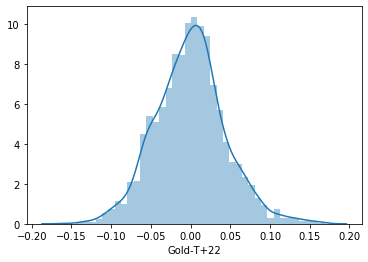

In [16]:
sns.distplot(data['Gold-T+22'])

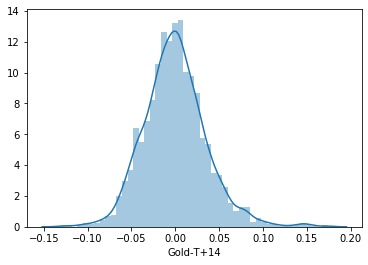

In [17]:
sns.distplot(data['Gold-T+14'])

In [18]:
data.to_csv("Training Data.csv",index=False)

##Creating Labels

We will try to predict any adverse (negative) return in Gold beyond a threshold.This threshold can be defined based on the risk tolerance of the investor. Here, I have taken the threshold to be 15% lowest return observations in the data history. In effect I am training to the model to predict a fall equal to or worse than 394 worse days in past 10 years.

In [19]:
import scipy.stats as st
#Select Threshold p (left tail probability)
p= 0.15
#Get z-Value
z = st.norm.ppf(p)
print(z)

-1.0364333894937898


In [20]:
#Calculating Threshold (t) for each Y
t_14 = round((z*np.std(data["Gold-T+14"]))+np.mean(data["Gold-T+14"]),5)
t_22 = round((z*np.std(data["Gold-T+22"]))+np.mean(data["Gold-T+22"]),5)

print("t_14=",t_14)
print("t_22=",t_22)

t_14= -0.03733
t_22= -0.04636


So We can see above that threshold for 14-day model is -0.037 or -3.7%. This means that Gold returns over 140day period has been lower than -3.7% only 15 out of 100 days. We will label them as Target outcomes. Similar for T+22 days and T+5 Days

In [21]:
#Creating Labels
data['Y-14'] = (data['Gold-T+14']< t_14)*1
data['Y-22']= (data['Gold-T+22']< t_22)*1
print("Y-14", sum(data['Y-14']))
print("Y-22", sum(data['Y-22']))

Y-14 338
Y-22 356


In [22]:
data.head()

,Date,Gold-T-1,Silver-T-1,Crude Oil-T-1,S&P500-T-1,Russel 2000 Index-T-1,10 Yr US T-Note futures-T-1,2 Yr US T-Note Futures-T-1,Platinum-T-1,Copper-T-1,...,Gold/30SMA,Gold/60SMA,Gold/90SMA,Gold/180SMA,Gold/90EMA,Gold/180EMA,Gold-T+14,Gold-T+22,Y-14,Y-22
0,2010-12-17,0.005984,0.010417,0.003421,0.000805,0.003734,0.008306,0.000913,0.001415,0.02439,...,-0.001805,0.012638,0.040506,0.092005,0.035494,0.070472,0.005250,0.007675,0,0
1,2010-12-20,0.005005,0.006873,0.009091,0.002573,0.003592,-0.000824,0.000000,0.007183,0.00000,...,0.003610,0.016601,0.044304,0.096390,0.039744,0.074871,0.012422,0.011166,0,0
2,2010-12-21,0.001949,0.003413,0.011261,0.006014,0.010482,-0.000824,-0.000912,0.006547,0.02381,...,0.006090,0.017567,0.044925,0.097391,0.040811,0.075992,0.010555,0.030969,0,0
3,2010-12-22,-0.001009,0.000000,0.007795,0.003348,0.000127,-0.009901,0.000000,0.005227,0.00000,...,0.005374,0.015569,0.042501,0.095189,0.038850,0.073962,0.002023,0.034154,0,0
4,2010-12-23,-0.004903,-0.003401,0.011050,-0.001589,-0.002024,-0.003333,0.000000,-0.004506,0.00000,...,0.001003,0.009699,0.036124,0.088766,0.032987,0.067834,-0.004113,0.026404,0,0


Now that we have the labels to predict, we can delet the return columns

In [23]:
data = data.drop(['Gold-T+14','Gold-T+22'],axis=1)
data.head()

,Date,Gold-T-1,Silver-T-1,Crude Oil-T-1,S&P500-T-1,Russel 2000 Index-T-1,10 Yr US T-Note futures-T-1,2 Yr US T-Note Futures-T-1,Platinum-T-1,Copper-T-1,...,MSCI EM ETF-T-250,Gold/15SMA,Gold/30SMA,Gold/60SMA,Gold/90SMA,Gold/180SMA,Gold/90EMA,Gold/180EMA,Y-14,Y-22
0,2010-12-17,0.005984,0.010417,0.003421,0.000805,0.003734,0.008306,0.000913,0.001415,0.02439,...,0.092219,-0.008206,-0.001805,0.012638,0.040506,0.092005,0.035494,0.070472,0,0
1,2010-12-20,0.005005,0.006873,0.009091,0.002573,0.003592,-0.000824,0.000000,0.007183,0.00000,...,0.086455,-0.004174,0.003610,0.016601,0.044304,0.096390,0.039744,0.074871,0,0
2,2010-12-21,0.001949,0.003413,0.011261,0.006014,0.010482,-0.000824,-0.000912,0.006547,0.02381,...,0.097421,-0.002386,0.006090,0.017567,0.044925,0.097391,0.040811,0.075992,0,0
3,2010-12-22,-0.001009,0.000000,0.007795,0.003348,0.000127,-0.009901,0.000000,0.005227,0.00000,...,0.097143,-0.003368,0.005374,0.015569,0.042501,0.095189,0.038850,0.073962,0,0
4,2010-12-23,-0.004903,-0.003401,0.011050,-0.001589,-0.002024,-0.003333,0.000000,-0.004506,0.00000,...,0.103448,-0.007851,0.001003,0.009699,0.036124,0.088766,0.032987,0.067834,0,0


## 22-Day Model

In [24]:
from pycaret.classification import *

In [65]:
data_22.head()

,Date,Gold-T-1,Silver-T-1,Crude Oil-T-1,S&P500-T-1,Russel 2000 Index-T-1,10 Yr US T-Note futures-T-1,2 Yr US T-Note Futures-T-1,Platinum-T-1,Copper-T-1,...,S&P500-T-250,MSCI EM ETF-T-250,Gold/15SMA,Gold/30SMA,Gold/60SMA,Gold/90SMA,Gold/180SMA,Gold/90EMA,Gold/180EMA,Y-22
0,2010-12-17,0.005984,0.010417,0.003421,0.000805,0.003734,0.008306,0.000913,0.001415,0.02439,...,0.097882,0.092219,-0.008206,-0.001805,0.012638,0.040506,0.092005,0.035494,0.070472,0
1,2010-12-20,0.005005,0.006873,0.009091,0.002573,0.003592,-0.000824,0.000000,0.007183,0.00000,...,0.100706,0.086455,-0.004174,0.003610,0.016601,0.044304,0.096390,0.039744,0.074871,0
2,2010-12-21,0.001949,0.003413,0.011261,0.006014,0.010482,-0.000824,-0.000912,0.006547,0.02381,...,0.103916,0.097421,-0.002386,0.006090,0.017567,0.044925,0.097391,0.040811,0.075992,0
3,2010-12-22,-0.001009,0.000000,0.007795,0.003348,0.000127,-0.009901,0.000000,0.005227,0.00000,...,0.107027,0.097143,-0.003368,0.005374,0.015569,0.042501,0.095189,0.038850,0.073962,0
4,2010-12-23,-0.004903,-0.003401,0.011050,-0.001589,-0.002024,-0.003333,0.000000,-0.004506,0.00000,...,0.100815,0.103448,-0.007851,0.001003,0.009699,0.036124,0.088766,0.032987,0.067834,0


In [70]:
data_22 = data.drop(['Y-14'],axis=1)
s22 = setup(data=data_22, target='Y-22', session_id=11, silent=True);

 
Setup Succesfully Completed!


,Description,Value
0,session_id,11
1,Target Type,Binary
2,Label Encoded,None
3,Original Data,"(2379, 109)"
4,Missing Values,False
5,Numeric Features,107
6,Categorical Features,0
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


In [77]:
compare_models(turbo=False)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,Extra Trees Classifier,0.9291,0.9721,0.6025,0.8957,0.7152,0.6769
1,Light Gradient Boosting Machine,0.9285,0.968,0.6025,0.8883,0.7129,0.6743
2,CatBoost Classifier,0.9261,0.9702,0.582,0.8932,0.7004,0.6607
3,MLP Classifier,0.9225,0.9469,0.6663,0.7863,0.7187,0.6743
4,Random Forest Classifier,0.9015,0.9162,0.4015,0.8816,0.5429,0.4975
5,Extreme Gradient Boosting,0.9015,0.9447,0.4092,0.8606,0.5496,0.5028
6,Gradient Boosting Classifier,0.8961,0.9343,0.4168,0.8051,0.5384,0.4878
7,Decision Tree Classifier,0.8847,0.768,0.6017,0.6237,0.6064,0.5394
8,Quadratic Discriminant Analysis,0.8805,0.9432,0.2407,0.8465,0.3691,0.3272
9,Ada Boost Classifier,0.8751,0.8683,0.345,0.6541,0.4482,0.3862


In [71]:
mlp = create_model('mlp')

,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,0.8922,0.9290,0.6000,0.6522,0.6250,0.5622
1,0.9401,0.9735,0.7200,0.8571,0.7826,0.7482
2,0.8982,0.9462,0.6000,0.6818,0.6383,0.5793
3,0.9521,0.9580,0.8000,0.8696,0.8333,0.8054
4,0.9341,0.9794,0.7200,0.8182,0.7660,0.7278
5,0.9157,0.9572,0.5833,0.7778,0.6667,0.6195
6,0.9157,0.9348,0.6000,0.7895,0.6818,0.6342
7,0.9096,0.9305,0.6800,0.7083,0.6939,0.6409
8,0.9217,0.9061,0.5600,0.8750,0.6829,0.6407
9,0.9458,0.9540,0.8000,0.8333,0.8163,0.7845


In [36]:
lgbm = create_model('lightgbm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,0.9461,0.9851,0.6800,0.9444,0.7907,0.7607
1,0.9042,0.9868,0.4000,0.9091,0.5556,0.5108
2,0.9281,0.9761,0.6800,0.8095,0.7391,0.6978
3,0.9222,0.9687,0.6000,0.8333,0.6977,0.6544
4,0.9222,0.9865,0.5200,0.9286,0.6667,0.6265
5,0.9277,0.9504,0.6250,0.8333,0.7143,0.6739
6,0.9337,0.9345,0.6800,0.8500,0.7556,0.7178
7,0.9217,0.9677,0.6000,0.8333,0.6977,0.6541
8,0.9398,0.9506,0.6000,1.0000,0.7500,0.7182
9,0.9398,0.9733,0.6400,0.9412,0.7619,0.7288


In [72]:
et = create_model('et')

,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,0.9222,0.9696,0.5600,0.8750,0.6829,0.6410
1,0.9162,0.9794,0.5200,0.8667,0.6500,0.6057
2,0.9222,0.9631,0.6800,0.7727,0.7234,0.6783
3,0.9222,0.9686,0.6000,0.8333,0.6977,0.6544
4,0.9341,0.9861,0.6400,0.8889,0.7442,0.7075
5,0.9398,0.9825,0.6250,0.9375,0.7500,0.7173
6,0.9578,0.9684,0.7200,1.0000,0.8372,0.8137
7,0.9337,0.9765,0.6800,0.8500,0.7556,0.7178
8,0.9157,0.9498,0.4400,1.0000,0.6111,0.5717
9,0.9277,0.9773,0.5600,0.9333,0.7000,0.6618


In [38]:
catb = create_model('catboost')

,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,0.9281,0.9707,0.5600,0.9333,0.7000,0.6621
1,0.9222,0.9856,0.5200,0.9286,0.6667,0.6265
2,0.9162,0.9510,0.6400,0.7619,0.6957,0.6475
3,0.9162,0.9611,0.5600,0.8235,0.6667,0.6207
4,0.9222,0.9837,0.6000,0.8333,0.6977,0.6544
5,0.9217,0.9680,0.5000,0.9231,0.6486,0.6089
6,0.9518,0.9793,0.6800,1.0000,0.8095,0.7831
7,0.9217,0.9753,0.6000,0.8333,0.6977,0.6541
8,0.9217,0.9543,0.4800,1.0000,0.6486,0.6106
9,0.9398,0.9725,0.6800,0.8947,0.7727,0.7387


In [26]:
mlp_tune = tune_model('mlp', n_iter=50,optimize='Recall')

,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,0.9042,0.9214,0.6400,0.6957,0.6667,0.6108
1,0.9042,0.9687,0.6400,0.6957,0.6667,0.6108
2,0.9042,0.9310,0.5600,0.7368,0.6364,0.5824
3,0.9162,0.9448,0.6400,0.7619,0.6957,0.6475
4,0.9162,0.9552,0.6400,0.7619,0.6957,0.6475
5,0.9096,0.9266,0.5833,0.7368,0.6512,0.6001
6,0.9277,0.9350,0.6000,0.8824,0.7143,0.6746
7,0.9036,0.9194,0.6000,0.7143,0.6522,0.5967
8,0.9036,0.8956,0.5200,0.7647,0.6190,0.5662
9,0.9217,0.9461,0.7600,0.7308,0.7451,0.6989


In [27]:
lgbm_tuned = tune_model('lightgbm',n_iter=50,optimize='Recall')

,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,0.9222,0.9642,0.6400,0.8000,0.7111,0.6668
1,0.9102,0.9166,0.5200,0.8125,0.6341,0.5857
2,0.9281,0.9420,0.6800,0.8095,0.7391,0.6978
3,0.8862,0.9180,0.4800,0.6667,0.5581,0.4948
4,0.9222,0.9727,0.5600,0.8750,0.6829,0.6410
5,0.8855,0.8694,0.4167,0.6667,0.5128,0.4519
6,0.9277,0.9401,0.6400,0.8421,0.7273,0.6865
7,0.9157,0.8783,0.5600,0.8235,0.6667,0.6204
8,0.8976,0.8817,0.4000,0.8333,0.5405,0.4908
9,0.8855,0.9257,0.5600,0.6364,0.5957,0.5294


In [31]:
et_tuned = tune_model ('et', n_iter=150)

,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,0.9222,0.9554,0.5600,0.8750,0.6829,0.6410
1,0.9281,0.9835,0.5600,0.9333,0.7000,0.6621
2,0.9281,0.9548,0.6400,0.8421,0.7273,0.6868
3,0.9281,0.9670,0.6400,0.8421,0.7273,0.6868
4,0.9162,0.9800,0.5200,0.8667,0.6500,0.6057
5,0.9337,0.9805,0.6250,0.8824,0.7317,0.6952
6,0.9277,0.9601,0.5600,0.9333,0.7000,0.6618
7,0.9337,0.9807,0.6800,0.8500,0.7556,0.7178
8,0.9157,0.9367,0.4400,1.0000,0.6111,0.5717
9,0.9337,0.9721,0.6400,0.8889,0.7442,0.7073


In [32]:
catb_tuned = tune_model('catboost',n_iter=150,optimize='Recall')

,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,0.8922,0.9344,0.6000,0.6522,0.6250,0.5622
1,0.9162,0.9687,0.5600,0.8235,0.6667,0.6207
2,0.9341,0.9538,0.6800,0.8500,0.7556,0.7180
3,0.9281,0.9470,0.7200,0.7826,0.7500,0.7081
4,0.9222,0.9699,0.5600,0.8750,0.6829,0.6410
5,0.9217,0.9334,0.5417,0.8667,0.6667,0.6250
6,0.9277,0.9282,0.6000,0.8824,0.7143,0.6746
7,0.9277,0.9455,0.6800,0.8095,0.7391,0.6975
8,0.9458,0.9597,0.6800,0.9444,0.7907,0.7605
9,0.9277,0.9481,0.6400,0.8421,0.7273,0.6865


#### Ensembling Modles

In [39]:
mlp_bagged = ensemble_model(estimator=mlp, method='Bagging')

,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,0.8862,0.9211,0.5200,0.6500,0.5778,0.5130
1,0.9162,0.9611,0.6000,0.7895,0.6818,0.6346
2,0.8982,0.9318,0.5200,0.7222,0.6047,0.5480
3,0.9401,0.9558,0.7200,0.8571,0.7826,0.7482
4,0.9162,0.9673,0.5200,0.8667,0.6500,0.6057
5,0.8916,0.9428,0.4583,0.6875,0.5500,0.4911
6,0.9217,0.9257,0.6400,0.8000,0.7111,0.6665
7,0.9277,0.9345,0.6800,0.8095,0.7391,0.6975
8,0.9217,0.8925,0.5600,0.8750,0.6829,0.6407
9,0.9458,0.9464,0.6800,0.9444,0.7907,0.7605


In [41]:
et_boosting = ensemble_model(estimator=et, method='Boosting')

,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,0.9102,0.9724,0.5200,0.8125,0.6341,0.5857
1,0.9102,0.9796,0.4800,0.8571,0.6154,0.5691
2,0.9162,0.9599,0.6400,0.7619,0.6957,0.6475
3,0.9222,0.9661,0.6000,0.8333,0.6977,0.6544
4,0.9102,0.9820,0.4800,0.8571,0.6154,0.5691
5,0.9277,0.9836,0.5417,0.9286,0.6842,0.6466
6,0.9518,0.9841,0.6800,1.0000,0.8095,0.7831
7,0.9217,0.9712,0.6000,0.8333,0.6977,0.6541
8,0.9217,0.9382,0.4800,1.0000,0.6486,0.6106
9,0.9398,0.9833,0.6000,1.0000,0.7500,0.7182


In [43]:
catb_tuned_boosted = ensemble_model(estimator=catb_tuned, method= 'Bagging')

,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,0.9222,0.9701,0.5200,0.9286,0.6667,0.6265
1,0.9102,0.9749,0.4400,0.9167,0.5946,0.5510
2,0.9162,0.9535,0.5600,0.8235,0.6667,0.6207
3,0.9281,0.9535,0.6400,0.8421,0.7273,0.6868
4,0.9162,0.9803,0.5200,0.8667,0.6500,0.6057
5,0.8855,0.9349,0.2917,0.7778,0.4242,0.3750
6,0.9096,0.9506,0.4800,0.8571,0.6154,0.5688
7,0.9337,0.9620,0.6400,0.8889,0.7442,0.7073
8,0.9096,0.9143,0.4000,1.0000,0.5714,0.5311
9,0.9217,0.9694,0.6000,0.8333,0.6977,0.6541


In [45]:
lgbm_bagged = ensemble_model(lgbm, method='Bagging')

,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,0.9222,0.9828,0.4800,1.0000,0.6486,0.6109
1,0.8922,0.9831,0.3200,0.8889,0.4706,0.4250
2,0.9222,0.9606,0.6000,0.8333,0.6977,0.6544
3,0.9042,0.9561,0.4800,0.8000,0.6000,0.5494
4,0.9102,0.9915,0.4400,0.9167,0.5946,0.5510
5,0.8976,0.9554,0.3333,0.8889,0.4848,0.4407
6,0.9217,0.9603,0.5600,0.8750,0.6829,0.6407
7,0.9157,0.9682,0.5200,0.8667,0.6500,0.6054
8,0.9157,0.9495,0.4400,1.0000,0.6111,0.5717
9,0.9337,0.9745,0.6000,0.9375,0.7317,0.6960


In [46]:
lgbm_boosted = ensemble_model(lgbm, method='Boosting')

,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,0.9461,0.9839,0.6400,1.0000,0.7805,0.7514
1,0.9102,0.9794,0.4800,0.8571,0.6154,0.5691
2,0.9281,0.9645,0.6800,0.8095,0.7391,0.6978
3,0.9222,0.9710,0.6000,0.8333,0.6977,0.6544
4,0.9341,0.9823,0.6400,0.8889,0.7442,0.7075
5,0.9277,0.9619,0.6250,0.8333,0.7143,0.6739
6,0.9337,0.9498,0.6800,0.8500,0.7556,0.7178
7,0.9096,0.9626,0.5200,0.8125,0.6341,0.5854
8,0.9217,0.9611,0.4800,1.0000,0.6486,0.6106
9,0.9217,0.9753,0.6000,0.8333,0.6977,0.6541


In [49]:
blend1 = blend_models(estimator_list=[mlp,lgbm,et])

,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,0.9341,0.0,0.6400,0.8889,0.7442,0.7075
1,0.9162,0.0,0.4800,0.9231,0.6316,0.5895
2,0.9222,0.0,0.6800,0.7727,0.7234,0.6783
3,0.9281,0.0,0.6400,0.8421,0.7273,0.6868
4,0.9401,0.0,0.6400,0.9412,0.7619,0.7291
5,0.9337,0.0,0.6250,0.8824,0.7317,0.6952
6,0.9398,0.0,0.6800,0.8947,0.7727,0.7387
7,0.9398,0.0,0.7200,0.8571,0.7826,0.7480
8,0.9277,0.0,0.5200,1.0000,0.6842,0.6479
9,0.9458,0.0,0.6800,0.9444,0.7907,0.7605


In [50]:
blend2 = blend_models(estimator_list=[lgbm,et], method='soft')

,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,0.9461,0.9817,0.6800,0.9444,0.7907,0.7607
1,0.9162,0.9848,0.4800,0.9231,0.6316,0.5895
2,0.9281,0.9693,0.6800,0.8095,0.7391,0.6978
3,0.9222,0.9715,0.6000,0.8333,0.6977,0.6544
4,0.9222,0.9873,0.5600,0.8750,0.6829,0.6410
5,0.9277,0.9783,0.6250,0.8333,0.7143,0.6739
6,0.9458,0.9626,0.6800,0.9444,0.7907,0.7605
7,0.9337,0.9750,0.6800,0.8500,0.7556,0.7178
8,0.9398,0.9495,0.6000,1.0000,0.7500,0.7182
9,0.9398,0.9830,0.6400,0.9412,0.7619,0.7288


### Stacking Models 

In [52]:
stack1 = create_stacknet(estimator_list=[[catb_tuned,blend2],[mlp]], restack=False)

,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,0.9461,0.9806,0.8000,0.8333,0.8163,0.7848
1,0.9341,0.9839,0.6400,0.8889,0.7442,0.7075
2,0.9341,0.9668,0.8000,0.7692,0.7843,0.7455
3,0.9581,0.9704,0.8400,0.8750,0.8571,0.8326
4,0.9641,0.9882,0.8800,0.8800,0.8800,0.8589
5,0.9398,0.9739,0.7083,0.8500,0.7727,0.7383
6,0.9458,0.9620,0.8000,0.8333,0.8163,0.7845
7,0.9518,0.9748,0.8800,0.8148,0.8462,0.8176
8,0.9458,0.9523,0.6400,1.0000,0.7805,0.7512
9,0.9578,0.9810,0.8000,0.9091,0.8511,0.8266


In [55]:
stacknet2 = stack_models(estimator_list=[catb_tuned,blend2], meta_model=mlp, restack=True)

,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,0.9162,0.9282,0.7600,0.7037,0.7308,0.6812
1,0.9401,0.9780,0.7200,0.8571,0.7826,0.7482
2,0.8982,0.9386,0.6400,0.6667,0.6531,0.5934
3,0.9281,0.9330,0.7600,0.7600,0.7600,0.7177
4,0.9341,0.9775,0.7600,0.7917,0.7755,0.7369
5,0.9217,0.9627,0.6667,0.7619,0.7111,0.6660
6,0.9217,0.8803,0.6800,0.7727,0.7234,0.6780
7,0.9157,0.9441,0.7600,0.7037,0.7308,0.6809
8,0.9337,0.9013,0.6400,0.8889,0.7442,0.7073
9,0.9518,0.9345,0.8000,0.8696,0.8333,0.8052


In [79]:
stack3 = stack_models(estimator_list=[catb_tuned,blend2], meta_model=mlp, restack=False)

,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,0.9461,0.9806,0.8000,0.8333,0.8163,0.7848
1,0.9521,0.9839,0.7600,0.9048,0.8261,0.7986
2,0.9341,0.9668,0.8000,0.7692,0.7843,0.7455
3,0.9641,0.9704,0.8800,0.8800,0.8800,0.8589
4,0.9641,0.9882,0.8800,0.8800,0.8800,0.8589
5,0.9458,0.9739,0.7500,0.8571,0.8000,0.7688
6,0.9337,0.9620,0.8000,0.7692,0.7843,0.7452
7,0.9578,0.9748,0.9200,0.8214,0.8679,0.8429
8,0.9458,0.9523,0.6400,1.0000,0.7805,0.7512
9,0.9639,0.9810,0.8400,0.9130,0.8750,0.8539


In [59]:
stack4 = create_stacknet(estimator_list=[[catb_tuned,blend2,mlp],[mlp]], restack=False)

,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,0.9401,0.9769,0.8000,0.8000,0.8000,0.7648
1,0.9521,0.9839,0.7600,0.9048,0.8261,0.7986
2,0.9281,0.9687,0.7600,0.7600,0.7600,0.7177
3,0.9641,0.9699,0.8800,0.8800,0.8800,0.8589
4,0.9641,0.9882,0.8800,0.8800,0.8800,0.8589
5,0.9458,0.9756,0.7500,0.8571,0.8000,0.7688
6,0.9398,0.9603,0.8000,0.8000,0.8000,0.7645
7,0.9518,0.9759,0.8800,0.8148,0.8462,0.8176
8,0.9458,0.9512,0.6400,1.0000,0.7805,0.7512
9,0.9639,0.9807,0.8400,0.9130,0.8750,0.8539


In [62]:
evaluate_model(mlp)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

In [73]:
evaluate_model(et)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

In [74]:
evaluate_model(lgbm)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

In [88]:
a =predict_model(stack3)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,Stacking Classifier,0.9636,0.9855,0.8692,0.8857,0.8774,0.856


In [91]:
a['Label'].sum()

105

In [92]:
a['Y-22'].sum()

107

In [90]:
a.shape

(714, 129)

In [80]:
classifier_22 = finalize_model(stack3)

In [82]:
save_model(classifier_22,"22D Classifier")

Transformation Pipeline and Model Succesfully Saved


## 14- Day Model

In [95]:
data_14 = data.drop(['Y-22'],axis=1)

In [97]:
s14 = setup(data=data_14, target='Y-14', session_id=11, silent=True, ignore_features=['Date']);

 
Setup Succesfully Completed!


,Description,Value
0,session_id,11
1,Target Type,Binary
2,Label Encoded,None
3,Original Data,"(2379, 109)"
4,Missing Values,False
5,Numeric Features,107
6,Categorical Features,0
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


In [100]:
compare_models(sort='Recall', turbo= False)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,MLP Classifier,0.9189,0.9365,0.6411,0.7671,0.6899,0.6442
1,K Neighbors Classifier,0.9171,0.9234,0.6375,0.753,0.6861,0.639
2,Decision Tree Classifier,0.8733,0.7376,0.548,0.5598,0.5485,0.4755
3,Light Gradient Boosting Machine,0.9147,0.9358,0.4893,0.8601,0.6122,0.5697
4,CatBoost Classifier,0.9081,0.9427,0.4422,0.8509,0.5732,0.5281
5,Naive Bayes,0.7286,0.6717,0.3926,0.2332,0.2916,0.1378
6,Extra Trees Classifier,0.9015,0.9466,0.379,0.8534,0.5184,0.4731
7,Gradient Boosting Classifier,0.8943,0.9041,0.3458,0.7903,0.4735,0.4267
8,Linear Discriminant Analysis,0.8727,0.7764,0.3284,0.5867,0.4157,0.3523
9,Extreme Gradient Boosting,0.8919,0.9121,0.3038,0.8597,0.4367,0.393


In [116]:
mlp14 = create_model('mlp')

,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,0.9281,0.9441,0.6250,0.8333,0.7143,0.6741
1,0.9222,0.9525,0.6250,0.7895,0.6977,0.6537
2,0.9341,0.9668,0.8333,0.7407,0.7843,0.7456
3,0.9222,0.9557,0.7083,0.7391,0.7234,0.6781
4,0.8922,0.9615,0.4583,0.6875,0.5500,0.4915
5,0.9458,0.9742,0.6522,0.9375,0.7692,0.7396
6,0.9217,0.9343,0.6957,0.7273,0.7111,0.6658
7,0.8976,0.8723,0.5217,0.6667,0.5854,0.5279
8,0.9277,0.8932,0.5417,0.9286,0.6842,0.6466
9,0.8976,0.9108,0.7500,0.6207,0.6792,0.6190


In [101]:
knn14_tuned = tune_model('knn', n_iter=100)

,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,0.9341,0.9394,0.7500,0.7826,0.7660,0.7277
1,0.9341,0.9317,0.7500,0.7826,0.7660,0.7277
2,0.9162,0.9304,0.7917,0.6786,0.7308,0.6815
3,0.9401,0.9371,0.8750,0.7500,0.8077,0.7725
4,0.9281,0.9527,0.6667,0.8000,0.7273,0.6863
5,0.9699,0.9693,0.9130,0.8750,0.8936,0.8761
6,0.9337,0.9526,0.8261,0.7308,0.7755,0.7368
7,0.9157,0.8313,0.6522,0.7143,0.6818,0.6333
8,0.9337,0.8831,0.7083,0.8095,0.7556,0.7174
9,0.9217,0.9171,0.8750,0.6774,0.7636,0.7176


In [109]:
dt14 = create_model('dt')

,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,0.8743,0.7879,0.6667,0.5517,0.6038,0.5298
1,0.8623,0.6942,0.4583,0.5238,0.4889,0.4097
2,0.8743,0.7532,0.5833,0.5600,0.5714,0.4978
3,0.8743,0.8052,0.7083,0.5484,0.6182,0.5444
4,0.8263,0.6039,0.2917,0.3684,0.3256,0.2275
5,0.8916,0.7364,0.5217,0.6316,0.5714,0.5100
6,0.8735,0.6894,0.4348,0.5556,0.4878,0.4169
7,0.9096,0.7651,0.5652,0.7222,0.6341,0.5835
8,0.8976,0.7843,0.6250,0.6522,0.6383,0.5787
9,0.8494,0.7562,0.6250,0.4839,0.5455,0.4569


In [104]:
dt_boosted = ensemble_model(dt, method='Boosting')

,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,0.8922,0.7984,0.6667,0.6154,0.6400,0.5767
1,0.8623,0.6942,0.4583,0.5238,0.4889,0.4097
2,0.8323,0.6767,0.4583,0.4231,0.4400,0.3416
3,0.8802,0.8260,0.7500,0.5625,0.6429,0.5727
4,0.8263,0.5865,0.2500,0.3529,0.2927,0.1970
5,0.8795,0.6929,0.4348,0.5882,0.5000,0.4333
6,0.8855,0.6964,0.4348,0.6250,0.5128,0.4503
7,0.9157,0.7504,0.5217,0.8000,0.6316,0.5863
8,0.8675,0.7148,0.5000,0.5455,0.5217,0.4450
9,0.8373,0.7837,0.7083,0.4595,0.5574,0.4632


In [111]:
blend14_1 = blend_models(estimator_list=[knn14_tuned,dt14,mlp14])

,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,0.9222,0.0,0.7083,0.7391,0.7234,0.6781
1,0.9401,0.0,0.6667,0.8889,0.7619,0.7285
2,0.9461,0.0,0.8333,0.8000,0.8163,0.7848
3,0.9222,0.0,0.7917,0.7037,0.7451,0.6993
4,0.8982,0.0,0.4583,0.7333,0.5641,0.5099
5,0.9578,0.0,0.7826,0.9000,0.8372,0.8131
6,0.9217,0.0,0.6522,0.7500,0.6977,0.6529
7,0.9217,0.0,0.6522,0.7500,0.6977,0.6529
8,0.9578,0.0,0.7083,1.0000,0.8293,0.8060
9,0.9157,0.0,0.8750,0.6562,0.7500,0.7005


In [114]:
stack14_1 = stack_models(estimator_list = [knn14_tuned, dt14, blend14_1], restack= False)

,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,0.9341,0.9353,0.7083,0.8095,0.7556,0.7177
1,0.9281,0.9331,0.6667,0.8000,0.7273,0.6863
2,0.9401,0.9371,0.7917,0.7917,0.7917,0.7567
3,0.9341,0.9333,0.7917,0.7600,0.7755,0.7369
4,0.9281,0.9703,0.6250,0.8333,0.7143,0.6741
5,0.9518,0.9696,0.6957,0.9412,0.8000,0.7733
6,0.9337,0.9510,0.7391,0.7727,0.7556,0.7172
7,0.9217,0.8297,0.5217,0.8571,0.6486,0.6075
8,0.9458,0.8820,0.6250,1.0000,0.7692,0.7404
9,0.9217,0.9302,0.8333,0.6897,0.7547,0.7086


In [117]:
stack14_2 = stack_models(estimator_list = [knn14_tuned, dt14, mlp14], meta_model= blend14_1,restack= True)

,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,0.9341,0.0,0.7500,0.7826,0.7660,0.7277
1,0.9281,0.0,0.7083,0.7727,0.7391,0.6976
2,0.9401,0.0,0.8333,0.7692,0.8000,0.7649
3,0.9162,0.0,0.7500,0.6923,0.7200,0.6708
4,0.9341,0.0,0.7083,0.8095,0.7556,0.7177
5,0.9578,0.0,0.7826,0.9000,0.8372,0.8131
6,0.9217,0.0,0.7391,0.7083,0.7234,0.6778
7,0.9036,0.0,0.5652,0.6842,0.6190,0.5644
8,0.9157,0.0,0.5833,0.7778,0.6667,0.6195
9,0.9036,0.0,0.8333,0.6250,0.7143,0.6577


In [118]:
stack14_3 = stack_models(estimator_list = [knn14_tuned, dt14, mlp14], meta_model= blend14_1,restack= False)

,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,0.9222,0.0,0.7083,0.7391,0.7234,0.6781
1,0.9042,0.0,0.5833,0.7000,0.6364,0.5817
2,0.8982,0.0,0.7083,0.6296,0.6667,0.6068
3,0.9222,0.0,0.7917,0.7037,0.7451,0.6993
4,0.8982,0.0,0.5417,0.6842,0.6047,0.5471
5,0.9398,0.0,0.6957,0.8421,0.7619,0.7278
6,0.9217,0.0,0.6957,0.7273,0.7111,0.6658
7,0.9096,0.0,0.5652,0.7222,0.6341,0.5835
8,0.9217,0.0,0.6250,0.7895,0.6977,0.6534
9,0.8735,0.0,0.6250,0.5556,0.5882,0.5138


In [119]:
classifier_14 = finalize_model(stack14_2)

In [120]:
save_model(classifier_14, "14D Classifier")

Transformation Pipeline and Model Succesfully Saved
